# Image Classification (Fashion-MNIST) Using Softmax Regression

The most commonly used image classification data set is the [MNIST](http://yann.lecun.com/exdb/mnist/) handwritten digit recognition data set, proposed by LeCun, Cortes and Burges in the 1990s.  
However, even simple models achieve classification accuracy over 95% on MNIST, so it is hard to spot the differences between better models and weaker ones.  
In order to get a better intuition, we will use the qualitatively similar, but comparatively complex [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset, proposed by [Xiao, Rasul and Vollgraf](https://arxiv.org/abs/1708.07747) in 2017.

## Getting the Data

First, import the packages or modules required in this section.



In [4]:
%matplotlib inline
import sys


import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import time

In [5]:
import common

Conveniently, PyTorch's `torchvision.datasets` package provides easy access to a number of benchmark vision datasets for testing our models.
The first time we invoke `data.vision.FashionMNIST(train=True)`
to collect the training data,
PyTorch will automatically retrieve the dataset via our Internet connection.
Subsequently, PyTorch will use the already-downloaded local copy.
We specify whether we are requesting the training set or the test set
by setting the value of the parameter `train` to `True` or `False`, respectively.
Recall that we will only be using the training data for training,
holding out the test set for a final evaluation of our model.

In [6]:
# By default pytorch torchvision datasets are of type PIL.
# Define a transform "trans" to change the PIL to Tensor format.
trans = transforms.Compose([
    transforms.ToTensor(), # [0, 1]
    transforms.Normalize((0.5,), (0.5,)) # (x-mean)/std = (x-0.5)/0.5--> -1<= x <= 1
    ])

The `ToTensor` Transform also moves the image channel from the last dimension to the first dimension to facilitate the convolutional neural network calculations introduced later.

In [8]:
mnist_train = torchvision.datasets.FashionMNIST(root="./data/", train=True, transform=trans, target_transform=None, download=True)
mnist_test = torchvision.datasets.FashionMNIST(root="./data", train=False, transform=trans, target_transform=None, download=True)

#print( dir(mnist_train) )
#print('\n')
print( mnist_train.data.shape, mnist_train.targets.shape )
print( mnist_test.data.shape, mnist_test.targets.shape )

100.0%


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100.0%


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100.0%


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100.0%

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

torch.Size([60000, 28, 28]) torch.Size([60000])
torch.Size([10000, 28, 28]) torch.Size([10000])


In [12]:
mnist_train

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [13]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

The number of images for each category in the training set and the testing set is 6,000 and 1,000, respectively. Since there are 10 categories, the numbers of examples in the training set and the test set are 60,000 and 10,000, respectively.

In [23]:
len(mnist_train), len(mnist_test)

(60000, 10000)

We can access any example by indexing into the dataset using square brackets `[]`. In the following code, we access the image and label corresponding to the first example.

In [9]:
feature, label = mnist_train[0]

Our example, stored here in the variable `feature` corresponds to an image with a height and width of 28 pixels. PyTorch automatically scales it into a tensor with each pixel value between 0 and 1. It is stored in a 3D Tensor. Its first dimension is the number of channels. Since the data set is a grayscale image, the number of channels is 1. When we encounter color, images, we'll have 3 channels for red, green, and blue. To keep things simple, we will record the shape of the image with the height and width of $h$ and $w$ pixels, respectively, as $h \times w$ or `(h, w)`.

In [10]:
label


9

The label of each image is represented as a scalar in PyTorch. Its type is a 64-bit integer.

In [26]:
label, type(label)

(9, int)

## Plot Images

`We need to reverse the normalization to draw images`



In [11]:
def rev_norm(img): # -1 <= ig <= 1
    img = (img + 1)/2
    img = torch.clip(img, 0, 1)
    return img

The following defines a function that can draw multiple images and corresponding labels in a single line.

Next, let's take a look at the image contents and text labels for the first nine examples in the training data set.

Note: PyTorch DataLoader objects don't support regular array slicing. You can instead iterate through.

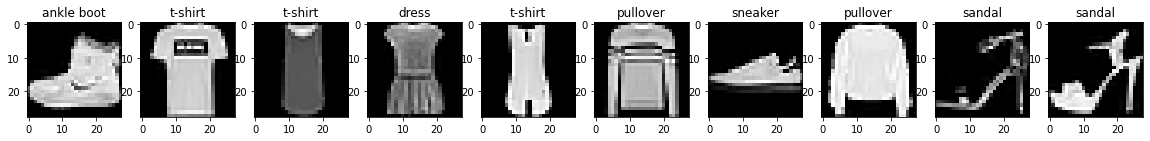

In [14]:
import matplotlib.pyplot as plt
text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
fig, axs = plt.subplots(1,10,figsize=(20, 2))
for i in range(10):
    img = mnist_train[i][0] #  <---- Normalization is included .
    img = rev_norm(img)
    label = mnist_train[i][1]
    axs[i].imshow(img.reshape((28, 28)), cmap='gray')
    axs[i].set_title(text_labels[label])

In [15]:
torch.min(img), torch.max(img)

(tensor(0.), tensor(1.))

## Reading a Minibatch

To make our life easier when reading from the training and test sets we use a `DataLoader` rather than creating one from scratch, as we did in `chapter_linear_scratch`. Recall that a data loader reads a mini-batch of data with an example number of `batch_size` each time.

In practice, reading data can often be a significant performance bottleneck for training, especially when the model is simple or when the computer is fast. A handy feature of PyTorch's `DataLoader` is the ability to use multiple processes to speed up data reading. For instance, we can set aside 4 processes to read the data (via `num_workers`).

We've already applied required transformations before.

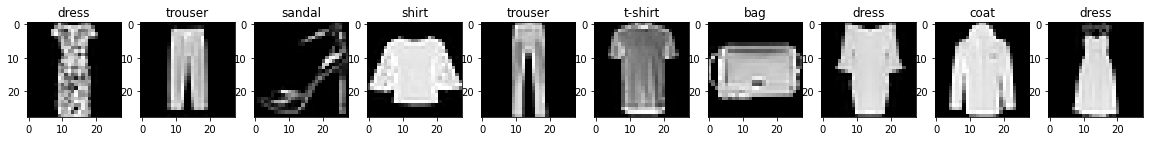

In [40]:
batch_size = 128
if sys.platform.startswith('win'):
    # set 0 for windows
    # 0 means no additional processes are needed to speed up the reading of data
    num_workers = 0
else:
    num_workers = 4

train_iter = DataLoader(mnist_train, batch_size, shuffle=True, num_workers=num_workers)
test_iter = DataLoader(mnist_test, batch_size, shuffle=False, num_workers=num_workers)


fig, axs = plt.subplots(1,10,figsize=(20, 2))
for imgs, labels in train_iter:
    i = 0
    for img, label in zip(imgs, labels):
        img = rev_norm(img)
        axs[i].imshow(img.reshape((28, 28)), cmap='gray')
        axs[i].set_title(text_labels[label])
        i += 1
    break

This function will return two variables, `train_iter` and `test_iter`. Let's look at the time it takes to read the training data.

In [41]:
for X, y in train_iter:
    print(X.shape, y.shape)
    break

torch.Size([10, 1, 28, 28]) torch.Size([10])


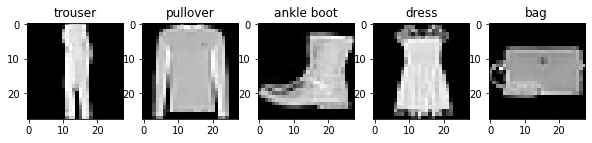

In [69]:
import matplotlib.pyplot as plt
batch_size = 5
train_loader = DataLoader(mnist_train, batch_size, shuffle=True, num_workers=num_workers)
train_iter = iter(train_iter)
img, label = next(train_iter)
img = rev_norm(img)
fig, axs = plt.subplots(1,batch_size,figsize=(10, 2))
for i in range(batch_size):
    axs[i].imshow(img[i].reshape((28, 28)), cmap='gray')
    axs[i].set_title(text_labels[label[i]])

In [71]:
torch.min(img), torch.max(img)

(tensor(0.), tensor(1.))